In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import sqlite3

In [5]:
con = sqlite3.connect("database.sqlite")

In [7]:
df = pd.read_sql_query("SELECT * FROM REVIEWS",con)

In [9]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [15]:
df.shape

(568454, 10)

## Data Preparation !
    Doing basic cleaning/Data wrangling(remove invalid rows , remove duplicate rows ..) & convert "time" feature data-type 
    to date-time

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [32]:
#Condition to check for invalid data where numerator can be greater than denominator
df_valid = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]

In [34]:
#Condition to check for single user to place multiple reviews so that we can remove those rows for complete transparency
df_valid.duplicated(subset = ['ProfileName', 'UserId', 'Time', 'Text']).sum()

174521

In [38]:
df_valid.drop_duplicates(subset = ['ProfileName', 'UserId', 'Time', 'Text'], inplace=True)

C:\Users\yuyu\AppData\Local\Temp\ipykernel_6656\1123205590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.drop_duplicates(subset = ['ProfileName', 'UserId', 'Time', 'Text'], inplace=True)


In [42]:
df_valid.shape

(393931, 10)

In [50]:
df_valid['Time'] = pd.to_datetime(df_valid['Time'], unit='s')

C:\Users\yuyu\AppData\Local\Temp\ipykernel_6656\254446583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Time'] = pd.to_datetime(df_valid['Time'], unit='s')


In [54]:
df_valid.dtypes

Id                                 int64
ProductId                         object
UserId                            object
ProfileName                       object
HelpfulnessNumerator               int64
HelpfulnessDenominator             int64
Score                              int64
Time                      datetime64[ns]
Summary                           object
Text                              object
dtype: object

### Analyse to what user Amazon can recommend more product ?
    Amazon can recommend more products to only those who are going to buy more or to one who has a better conversion rate,so lets ready data according to this problem statement

In [59]:
recommended_df = df_valid.groupby('UserId').agg({'ProductId':'count', 'Score':'mean'}).sort_values(by = 'ProductId', ascending = False)

In [85]:
recommended_df['Score'] = np.round(recommended_df['Score'], 2)

In [91]:
recommended_df.columns = ['Products_Purchased', "Avg_Ratings"]

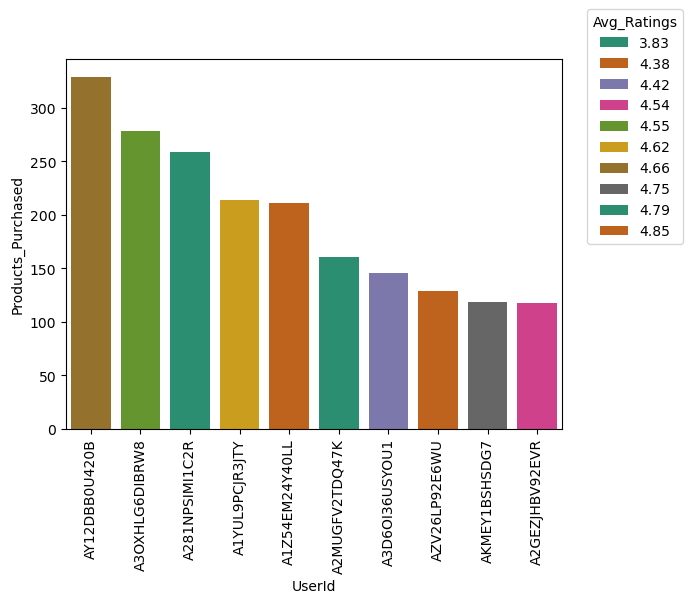

In [105]:
sns.barplot(x=recommended_df.index[:10], y=recommended_df['Products_Purchased'][:10], hue = recommended_df['Avg_Ratings'][:10], palette='Dark2')
plt.xticks(rotation='vertical')
plt.legend(title = 'Avg_Ratings', loc = (1.05,0.5))

In [ ]:
'''
Inference : These are the Top 10 users to whom we can recommend more & more products to these User Id 
            as there will be a high probability that these person are going to be buy more
            
'''

# Which product has good number of reviews ? 

In [112]:
prod_count = df_valid['ProductId'].value_counts()

In [128]:
most_freq = prod_count[prod_count > 500].index

In [130]:
most_freq

Index(['B007JFMH8M', 'B002QWP89S', 'B003B3OOPA', 'B001EO5Q64', 'B0013NUGDE',
       'B000KV61FC', 'B000UBD88A', 'B000NMJWZO', 'B005K4Q37A', 'B0090X8IPM',
       'B005ZBZLT4'],
      dtype='object', name='ProductId')

In [136]:
most_freq_df = df_valid[df_valid['ProductId'].isin(most_freq)]

In [140]:
most_freq_df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

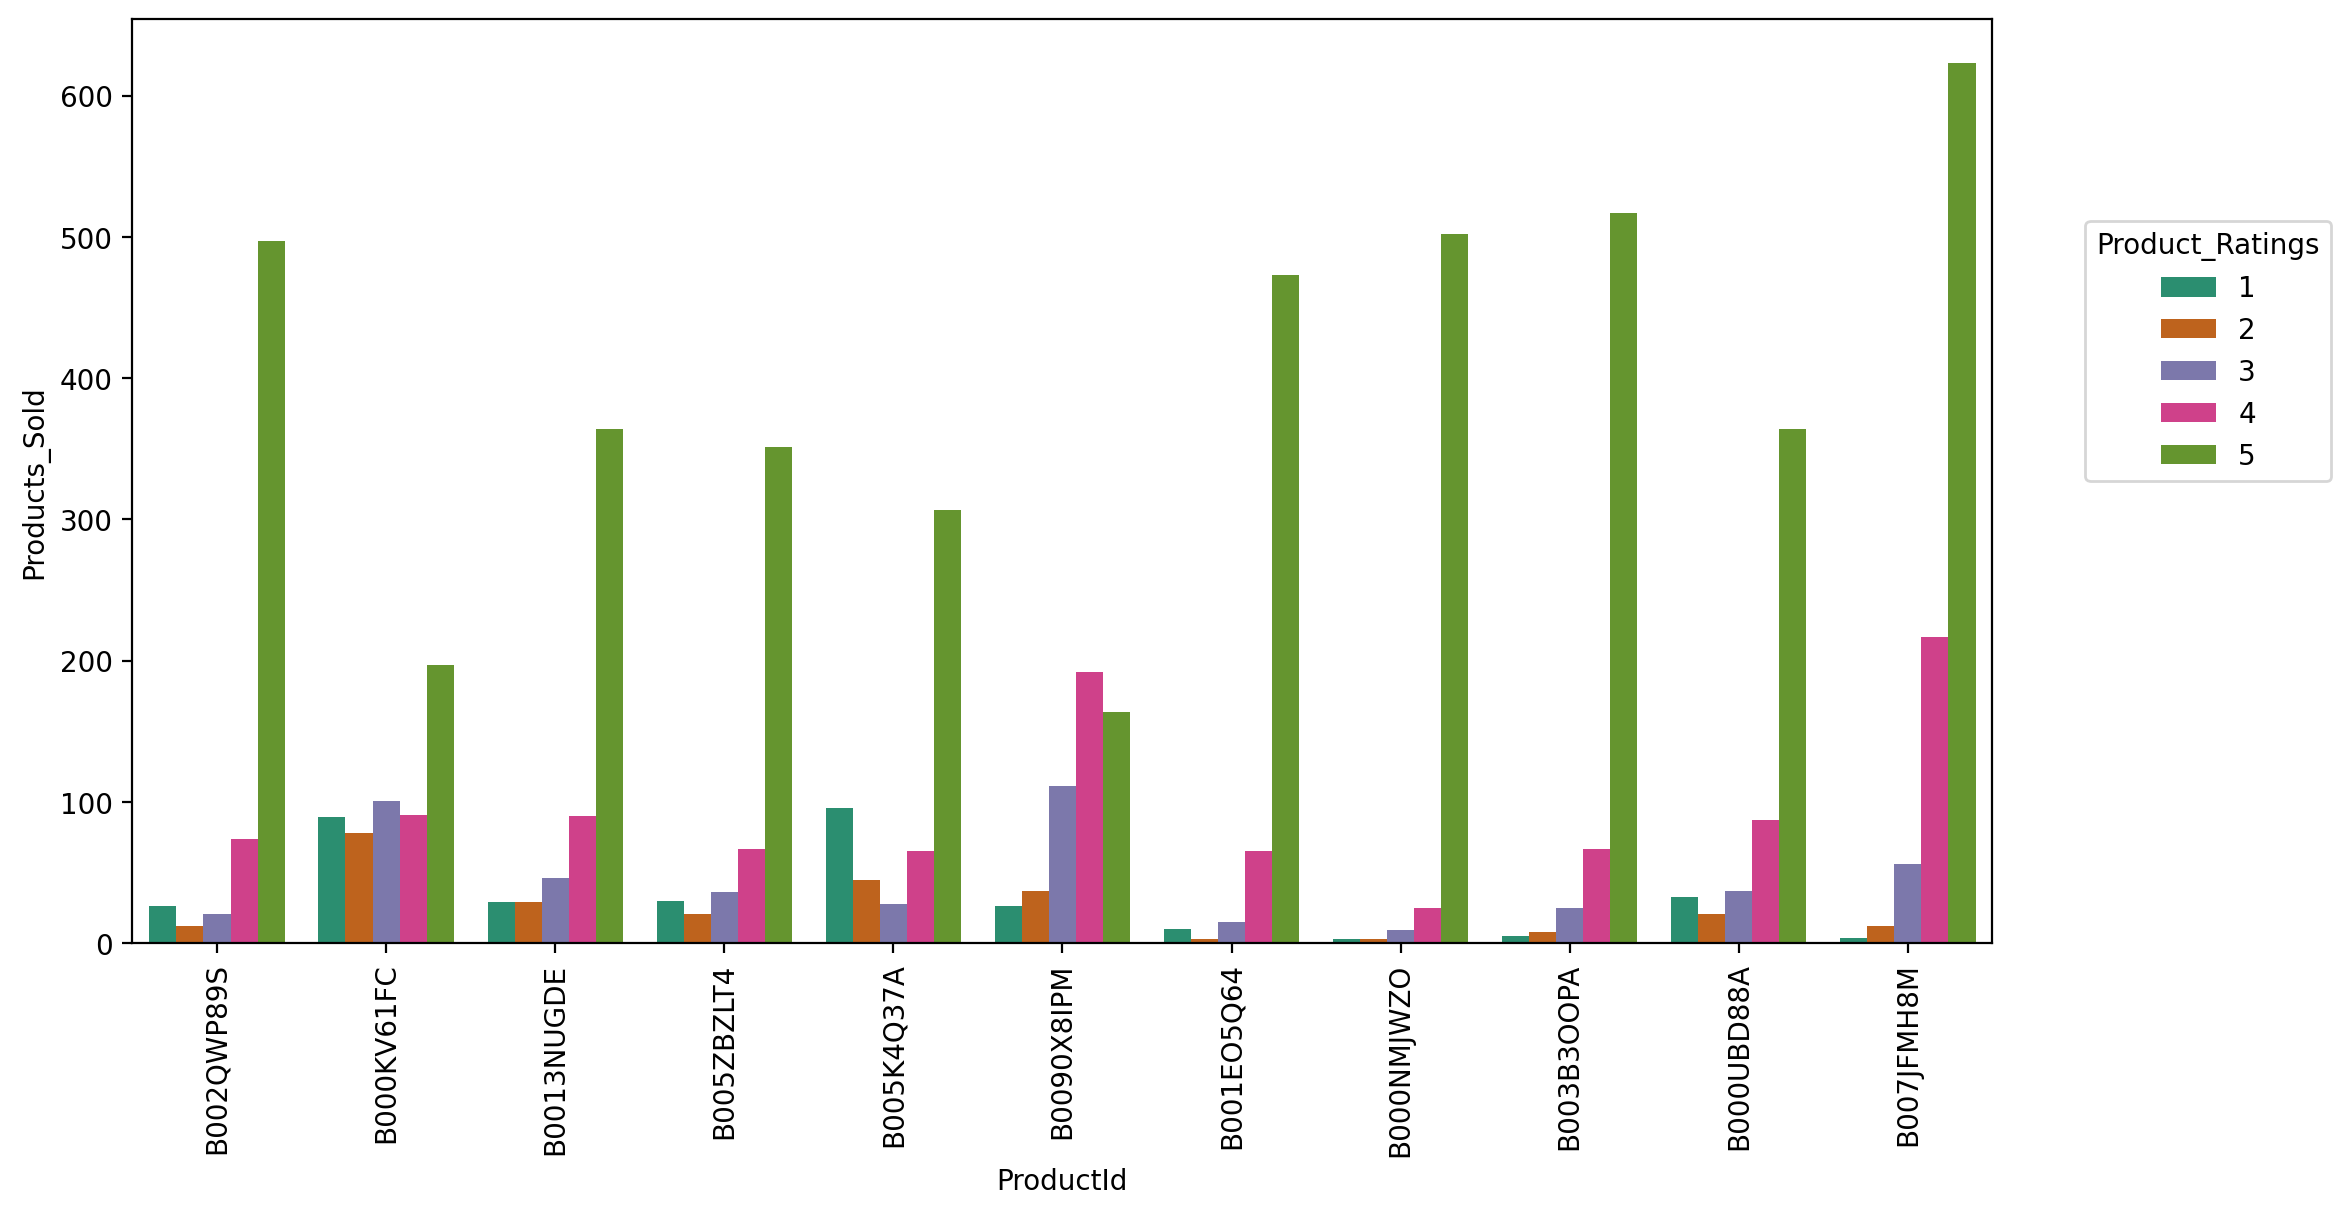

In [148]:
plt.figure(figsize=(12,6), dpi = 200)
sns.countplot(x='ProductId', data=most_freq_df, hue='Score', palette = 'Dark2')
plt.xticks(rotation = 'vertical')
plt.ylabel('Products_Sold')
plt.legend(loc=(1.05,0.5), title = 'Product_Ratings');

In [ ]:
''' List of top products that are sold over 500 times with reviews segregation '''

# Is there any difference between behaviour of frequent viewers & not frequent viewers ?

In [155]:
x = df_valid['UserId'].value_counts()

In [157]:
df_valid['Cust_Type'] = df_valid['UserId'].apply(lambda user: 'frequent' if x[user]>50 else 'not frequent')

C:\Users\yuyu\AppData\Local\Temp\ipykernel_6656\3317338318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Cust_Type'] = df_valid['UserId'].apply(lambda user: 'frequent' if x[user]>50 else 'not frequent')


In [159]:
df_valid.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cust_Type
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,not frequent
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not frequent
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,not frequent
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,not frequent
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,not frequent


In [163]:
most_freq = df_valid[df_valid['Cust_Type'] == 'frequent']

In [165]:
not_freq = df_valid[df_valid['Cust_Type'] == 'not frequent']

In [177]:
freq_percent = np.round(most_freq['Score'].value_counts()/len(most_freq)*100, 2)

In [181]:
not_freq_percent = np.round(not_freq['Score'].value_counts()/len(not_freq)*100, 2)

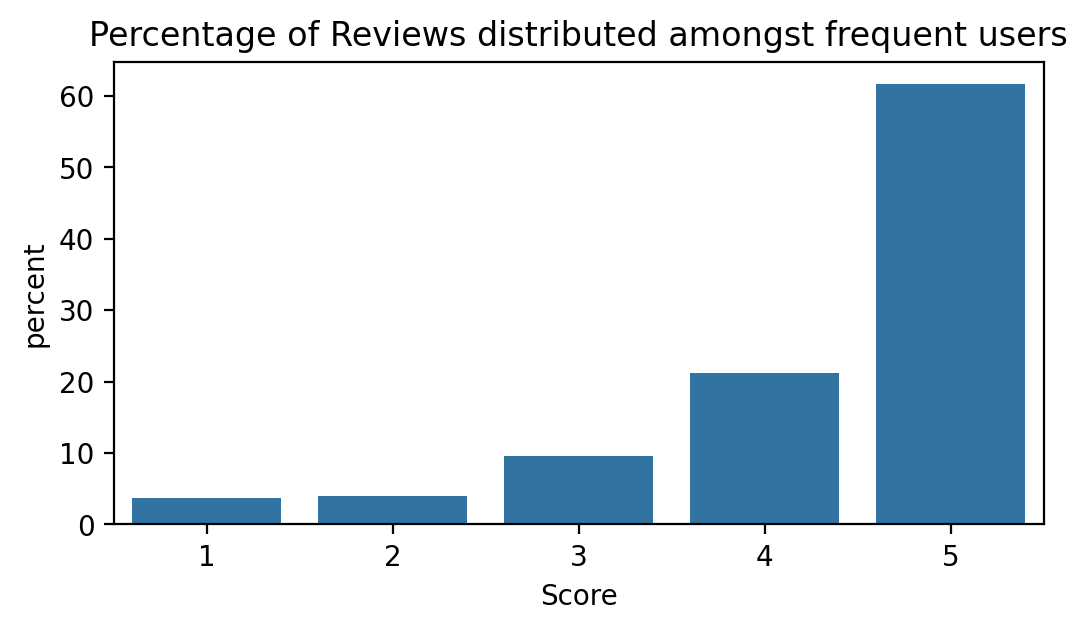

In [189]:
plt.figure(figsize = (6,3), dpi =200)
sns.countplot(x='Score', data=most_freq, stat = 'percent')
plt.title("Percentage of Reviews distributed amongst frequent users");

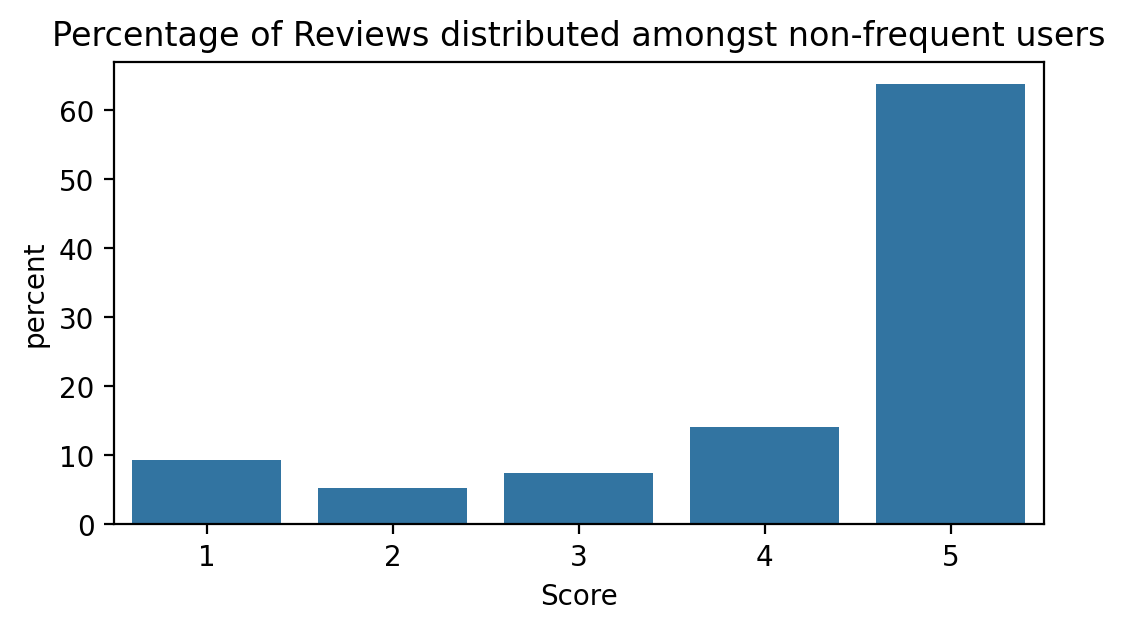

In [191]:
plt.figure(figsize = (6,3), dpi =200)
sns.countplot(x='Score', data=not_freq, stat = 'percent')
plt.title("Percentage of Reviews distributed amongst non-frequent users");

In [ ]:
'''
The distribution of ratings among frequent reviewers is similar to that of all reviews. 
However, we can see that frequent reviewers give less 5-star reviews and less 1-star review.
Frequent users appear to be more discerning in the sense that they give less extreme reviews than infrequent reviews.

'''

# Are frequent users more verbose ?  ( ie someone who speaks or post alot )

In [196]:
most_freq['Text_Length'] = most_freq['Text'].apply(lambda line: len(line.split(" ")) )

C:\Users\yuyu\AppData\Local\Temp\ipykernel_6656\1552067607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_freq['Text_Length'] = most_freq['Text'].apply(lambda line: len(line.split(" ")) )


In [198]:
most_freq.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cust_Type,Text_Length
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,2010-03-12,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,frequent,22
44,45,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0,0,5,2008-05-02,Great taste and convenience,We really like the McCann's steel cut oats but...,frequent,44
46,47,B001EO5QW8,AQLL2R1PPR46X,grumpyrainbow,0,0,5,2007-10-19,good,Good oatmeal. I like the apple cinnamon the b...,frequent,50
109,110,B001REEG6C,AY12DBB0U420B,Gary Peterson,0,0,5,2011-09-19,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh ...,frequent,134
141,142,B001GVISJW,A2YIO225BTKVPU,"Angel_Boy ""Treat the people around you the wa...",0,0,4,2011-04-03,Good Licorice,Twizzlers brand licorice is much better than t...,frequent,47


In [200]:
not_freq['Text_Length'] = not_freq['Text'].apply(lambda line: len(line.split(" ")) )

C:\Users\yuyu\AppData\Local\Temp\ipykernel_6656\3278181862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_freq['Text_Length'] = not_freq['Text'].apply(lambda line: len(line.split(" ")) )


In [202]:
not_freq.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cust_Type,Text_Length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,not frequent,49
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not frequent,31
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,not frequent,99
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,not frequent,43
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,not frequent,30


(0.0, 800.0)

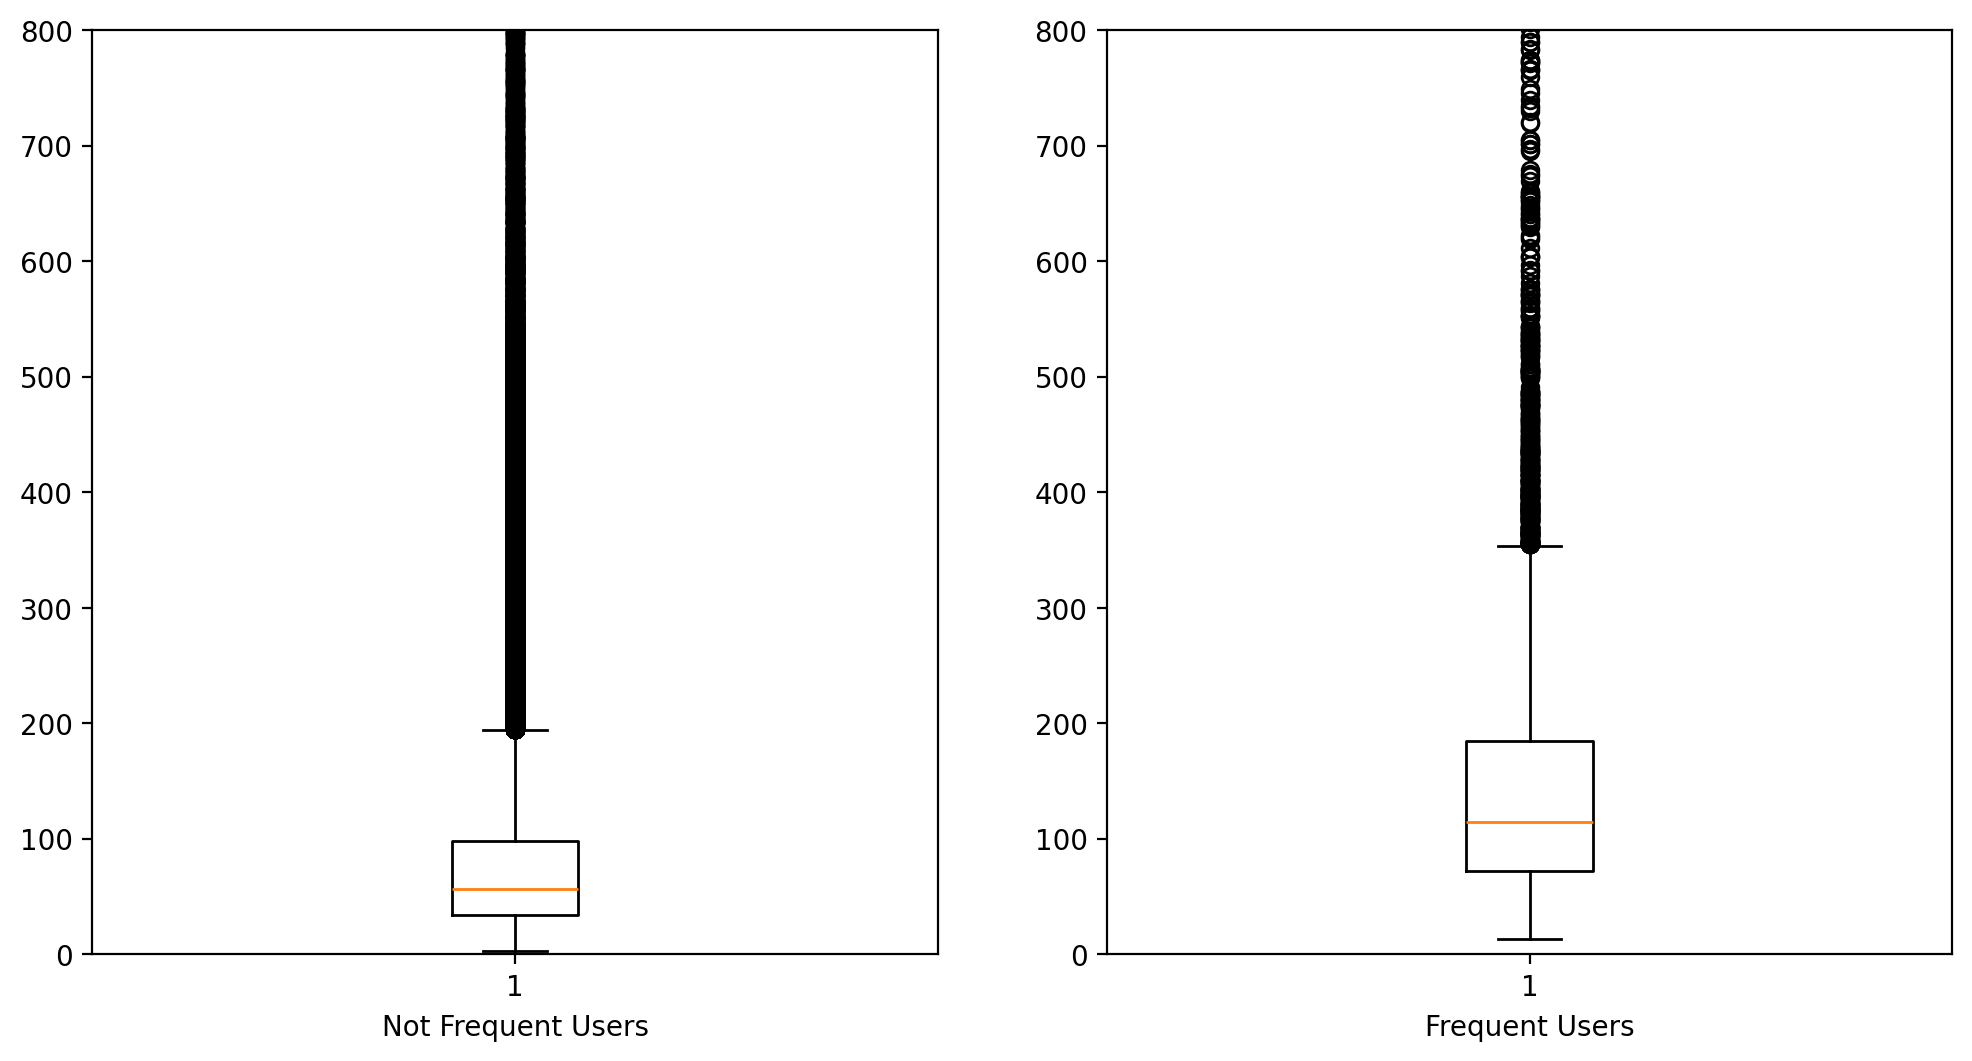

In [222]:
fig = plt.figure(figsize=(12,6), dpi=200)

ax1 = fig.add_subplot(121)
ax1.boxplot(not_freq['Text_Length'])
ax1.set_xlabel("Not Frequent Users")
ax1.set_ylim(0,800)

ax2 = fig.add_subplot(122)
ax2.boxplot(most_freq['Text_Length'])
ax2.set_xlabel("Frequent Users")
ax2.set_ylim(0,800)

In [ ]:
'''
Conclusion : 

The distributions of word counts for frequent and infrequent reviews shows that 
infrequent reviewers have a large amount of reviews of low word count.
On the other hand, the largest concentration of word count is higher for frequent reviewers than for infrequent reviews. 



'''

# Sentiment Analysis
    Sentiment analysis is the computational task of automatically determining what feelings a writer is expressing in text
    Some examples of applications for sentiment analysis include:

    1. Analyzing the social media discussion around a certain topic
    2. Evaluating survey responses
    3. Determining whether product reviews are positive or negative

In [226]:
!pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 626.3/626.3 kB 7.7 MB/s eta 0:00:00


In [228]:
from textblob import TextBlob

In [232]:
sample = df_valid[0:50000]

In [234]:
polarity = []
for text in sample['Summary']:
    try:
        polarity.append(TextBlob(text).sentiment.polarity)
    except:
        polarity.append(0)

In [236]:
len(polarity)

50000

In [238]:
sample['Polarity'] = polarity

C:\Users\yuyu\AppData\Local\Temp\ipykernel_6656\619119353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Polarity'] = polarity


In [240]:
sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cust_Type,Polarity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,not frequent,0.7
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not frequent,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,not frequent,0.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,not frequent,0.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,not frequent,0.8


In [242]:
positive_reviews = sample[sample['Polarity']>=0]
negative_reviews  = sample[sample['Polarity']<0]

In [244]:
from collections import Counter

In [246]:
Counter(positive_reviews['Summary']).most_common(10)

[('Delicious!', 208),
 ('Delicious', 204),
 ('Yummy!', 142),
 ('Great product', 100),
 ('Yum!', 100),
 ('Yummy', 92),
 ('Excellent', 85),
 ('Love it!', 81),
 ('Great', 81),
 ('Great Product', 77)]

In [248]:
Counter(negative_reviews['Summary']).most_common(10)

[('Disappointed', 44),
 ('Disappointing', 32),
 ('Bland', 18),
 ('Awful', 17),
 ('Not what I expected', 17),
 ('Terrible', 15),
 ('Horrible', 15),
 ('disappointed', 15),
 ('Disgusting', 12),
 ('not good', 11)]